In [1]:
import backtester272 as bt
import pandas as pd
import numpy as np

# Load data

In [2]:
def load_data(name):
    data = pd.read_csv(f'data/{name}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.sort_index()
    return data


#benchmark = load_data('benchmark')
weights = load_data('weights')  
sectors = load_data('sectors')


In [4]:
db_macro = bt.DataMacro()
# print(db_macro.cpi.head())
# print(db_macro.refi_rate.head())
# print(db_macro.yield_10Y.head())
# print(db_macro.sensitivity_matrix.head())

c:\Users\thibc\OneDrive\Documents\Dev\Cross-Assets-Solutions\framework\backtester272\DataMacro.py:25: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.yield_10Y = pd.read_csv(yield_10Y_path, index_col=0, parse_dates=True).sort_index().astype(float)


In [3]:
wip = bt.Backtester(sectors, benchmark_weights=weights)

In [ ]:
start_date = sectors.index[0].strftime('%Y-%m-%d')
end_date = sectors.index[-1].strftime('%Y-%m-%d')

global_params = {
    'start_date': start_date,
    'end_date': end_date,
    'freq': 30 * 18,
    'window': 30 * 18,
    'freq_tactical': 30,
    'window_tactical': 30 * 12,
    'aum': 100,
    'transaction_cost': 0
}

stategy_constraints = {
    'max_weight': 0.35,
    'min_weight': 0.05,
    'risk_free_rate': 0.02,
    'total_exposure': 1.0,
    'max_turnover': 1.5,
    'max_tracking_error': 0.07,
    'lmd_ridge': 2
}

tactical_constraints = {
    'delta': 30,
    'nb_fractile':4,
    'alpha': 0.10 
}

macro_constraints = {
    'alpha_macro': 0.10
}

MSM = wip.run(**global_params, strategy=bt.MaxSharpeStrategy(**stategy_constraints), tactical=bt.MomentumTactical(**tactical_constraints))

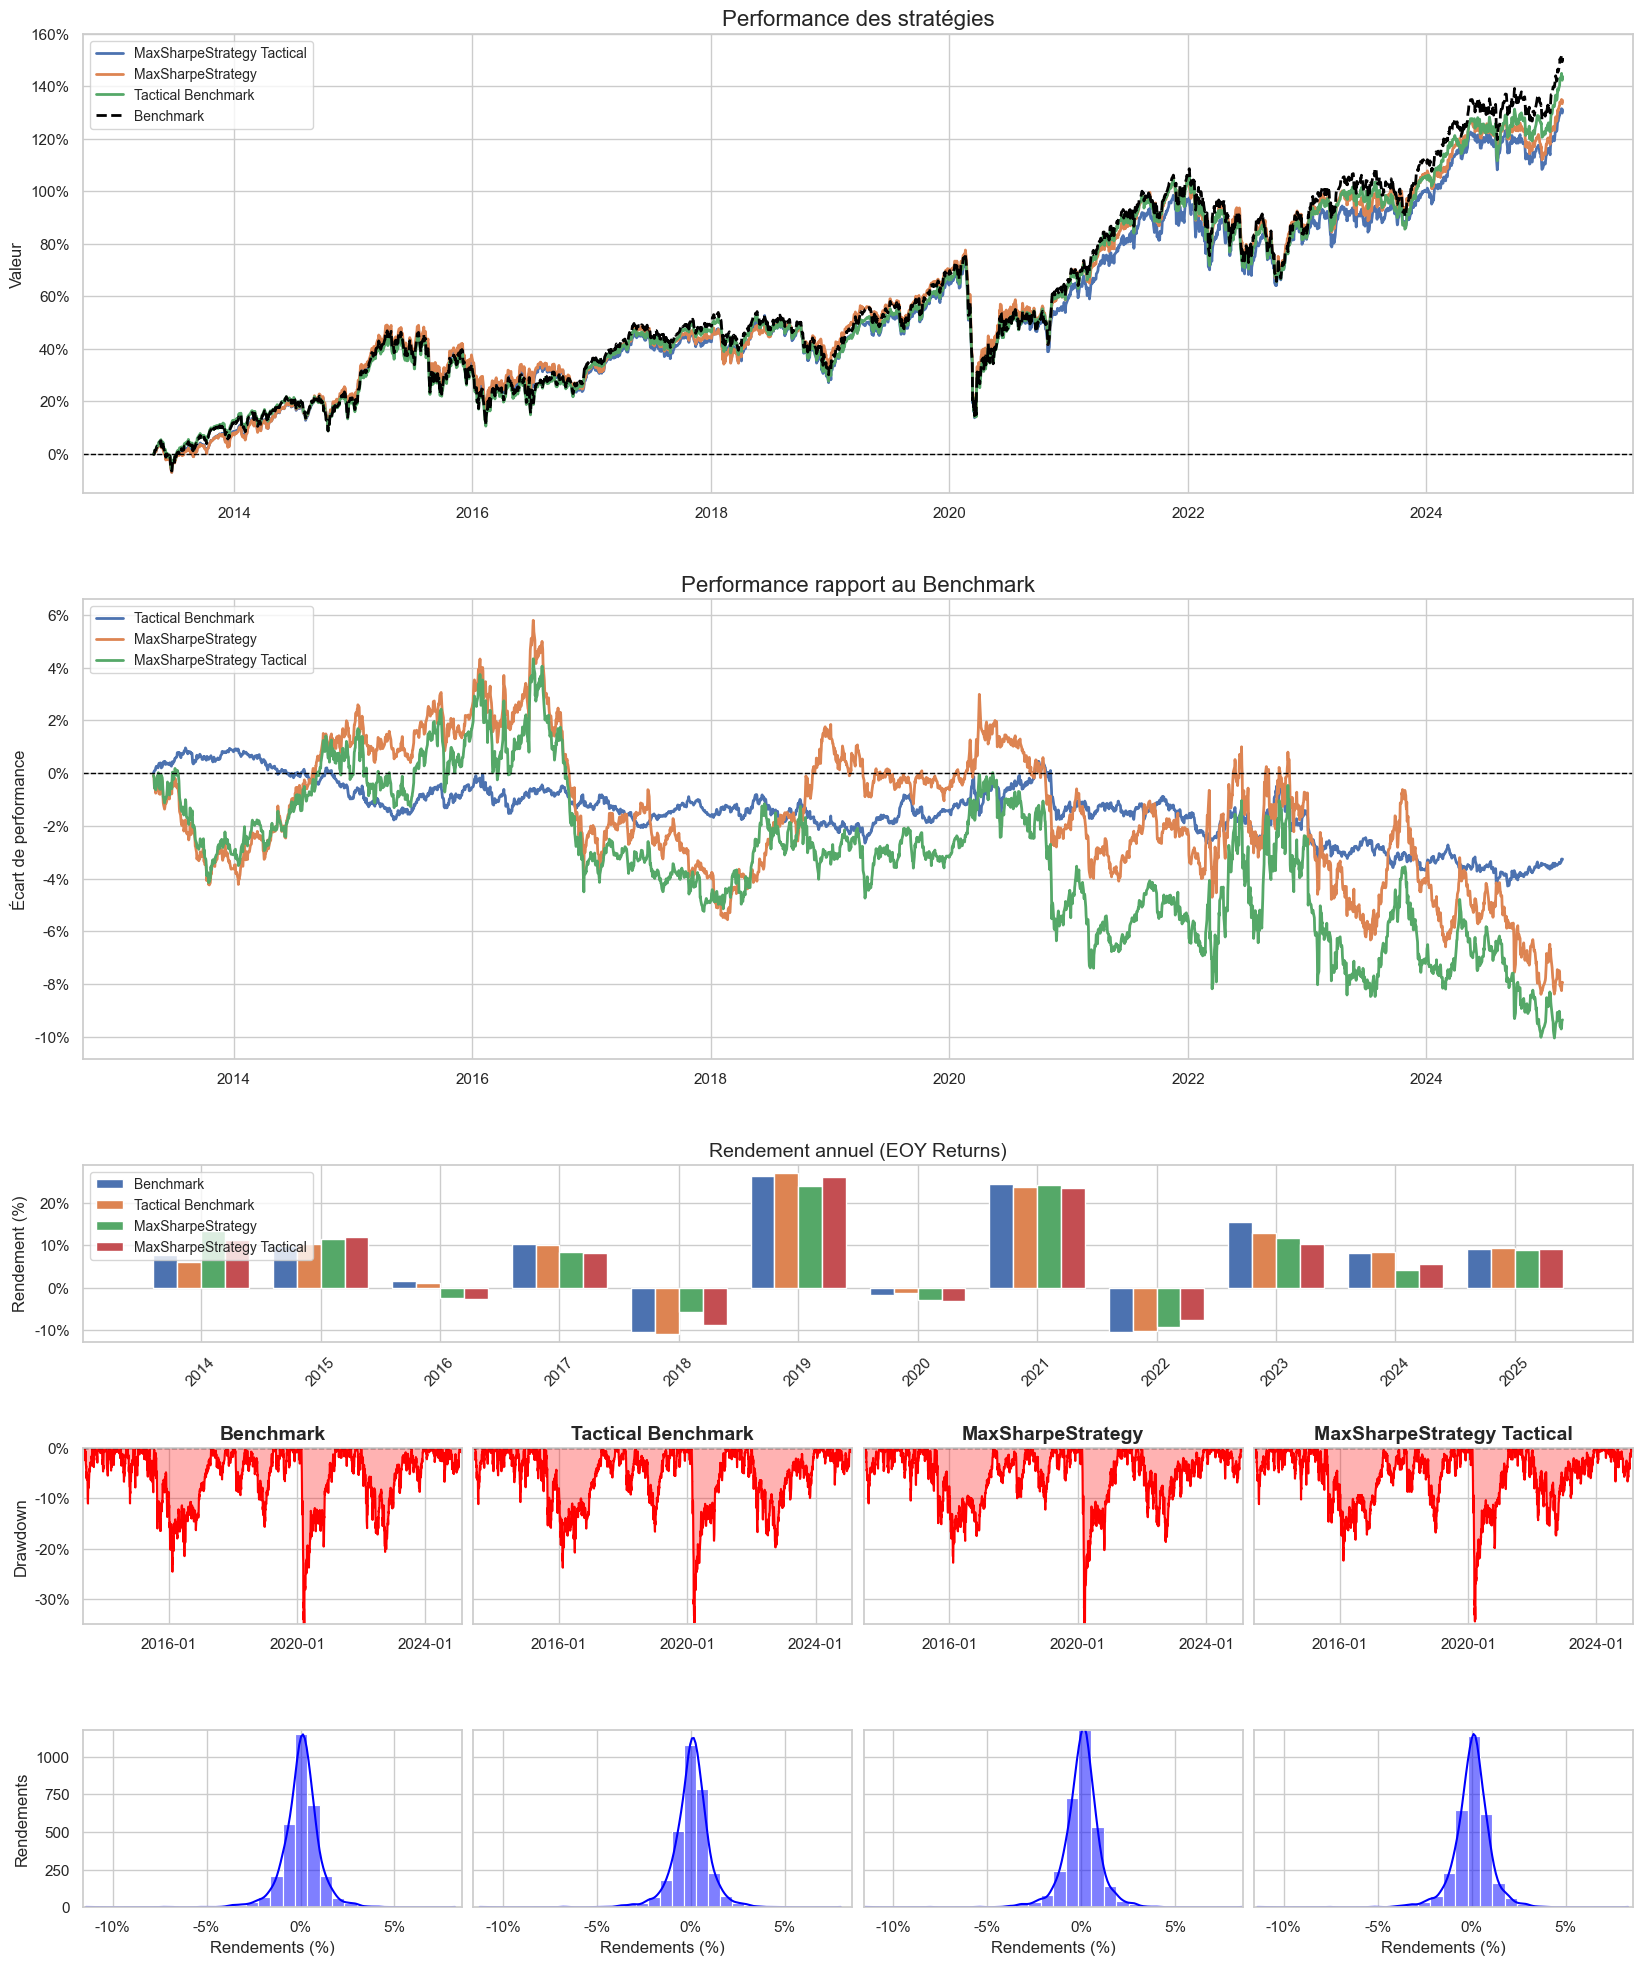

|                              | Benchmark   | Tactical Benchmark   | MaxSharpeStrategy   | MaxSharpeStrategy Tactical   |
|:-----------------------------|:------------|:---------------------|:--------------------|:-----------------------------|
| Performance                  | 150.86%     | 143.81%              | 134.73%             | 131.19%                      |
| CAGR                         | 7.93%       | 7.68%                | 7.34%               | 7.20%                        |
| Volatility                   | 15.57%      | 15.39%               | 15.14%              | 15.26%                       |
| Max Drawdown                 | -34.93%     | -34.52%              | -34.77%             | -34.34%                      |
| Sharpe Ratio                 | 0.57        | 0.56                 | 0.54                | 0.53                         |
| Annualized Transactions Cost | 0.00%       | 0.00%                | 0.00%               | 0.00%                        |
| Tracking Error

In [10]:
MSM.visualize()
MSM.positions("tactical")
MSM.positions()

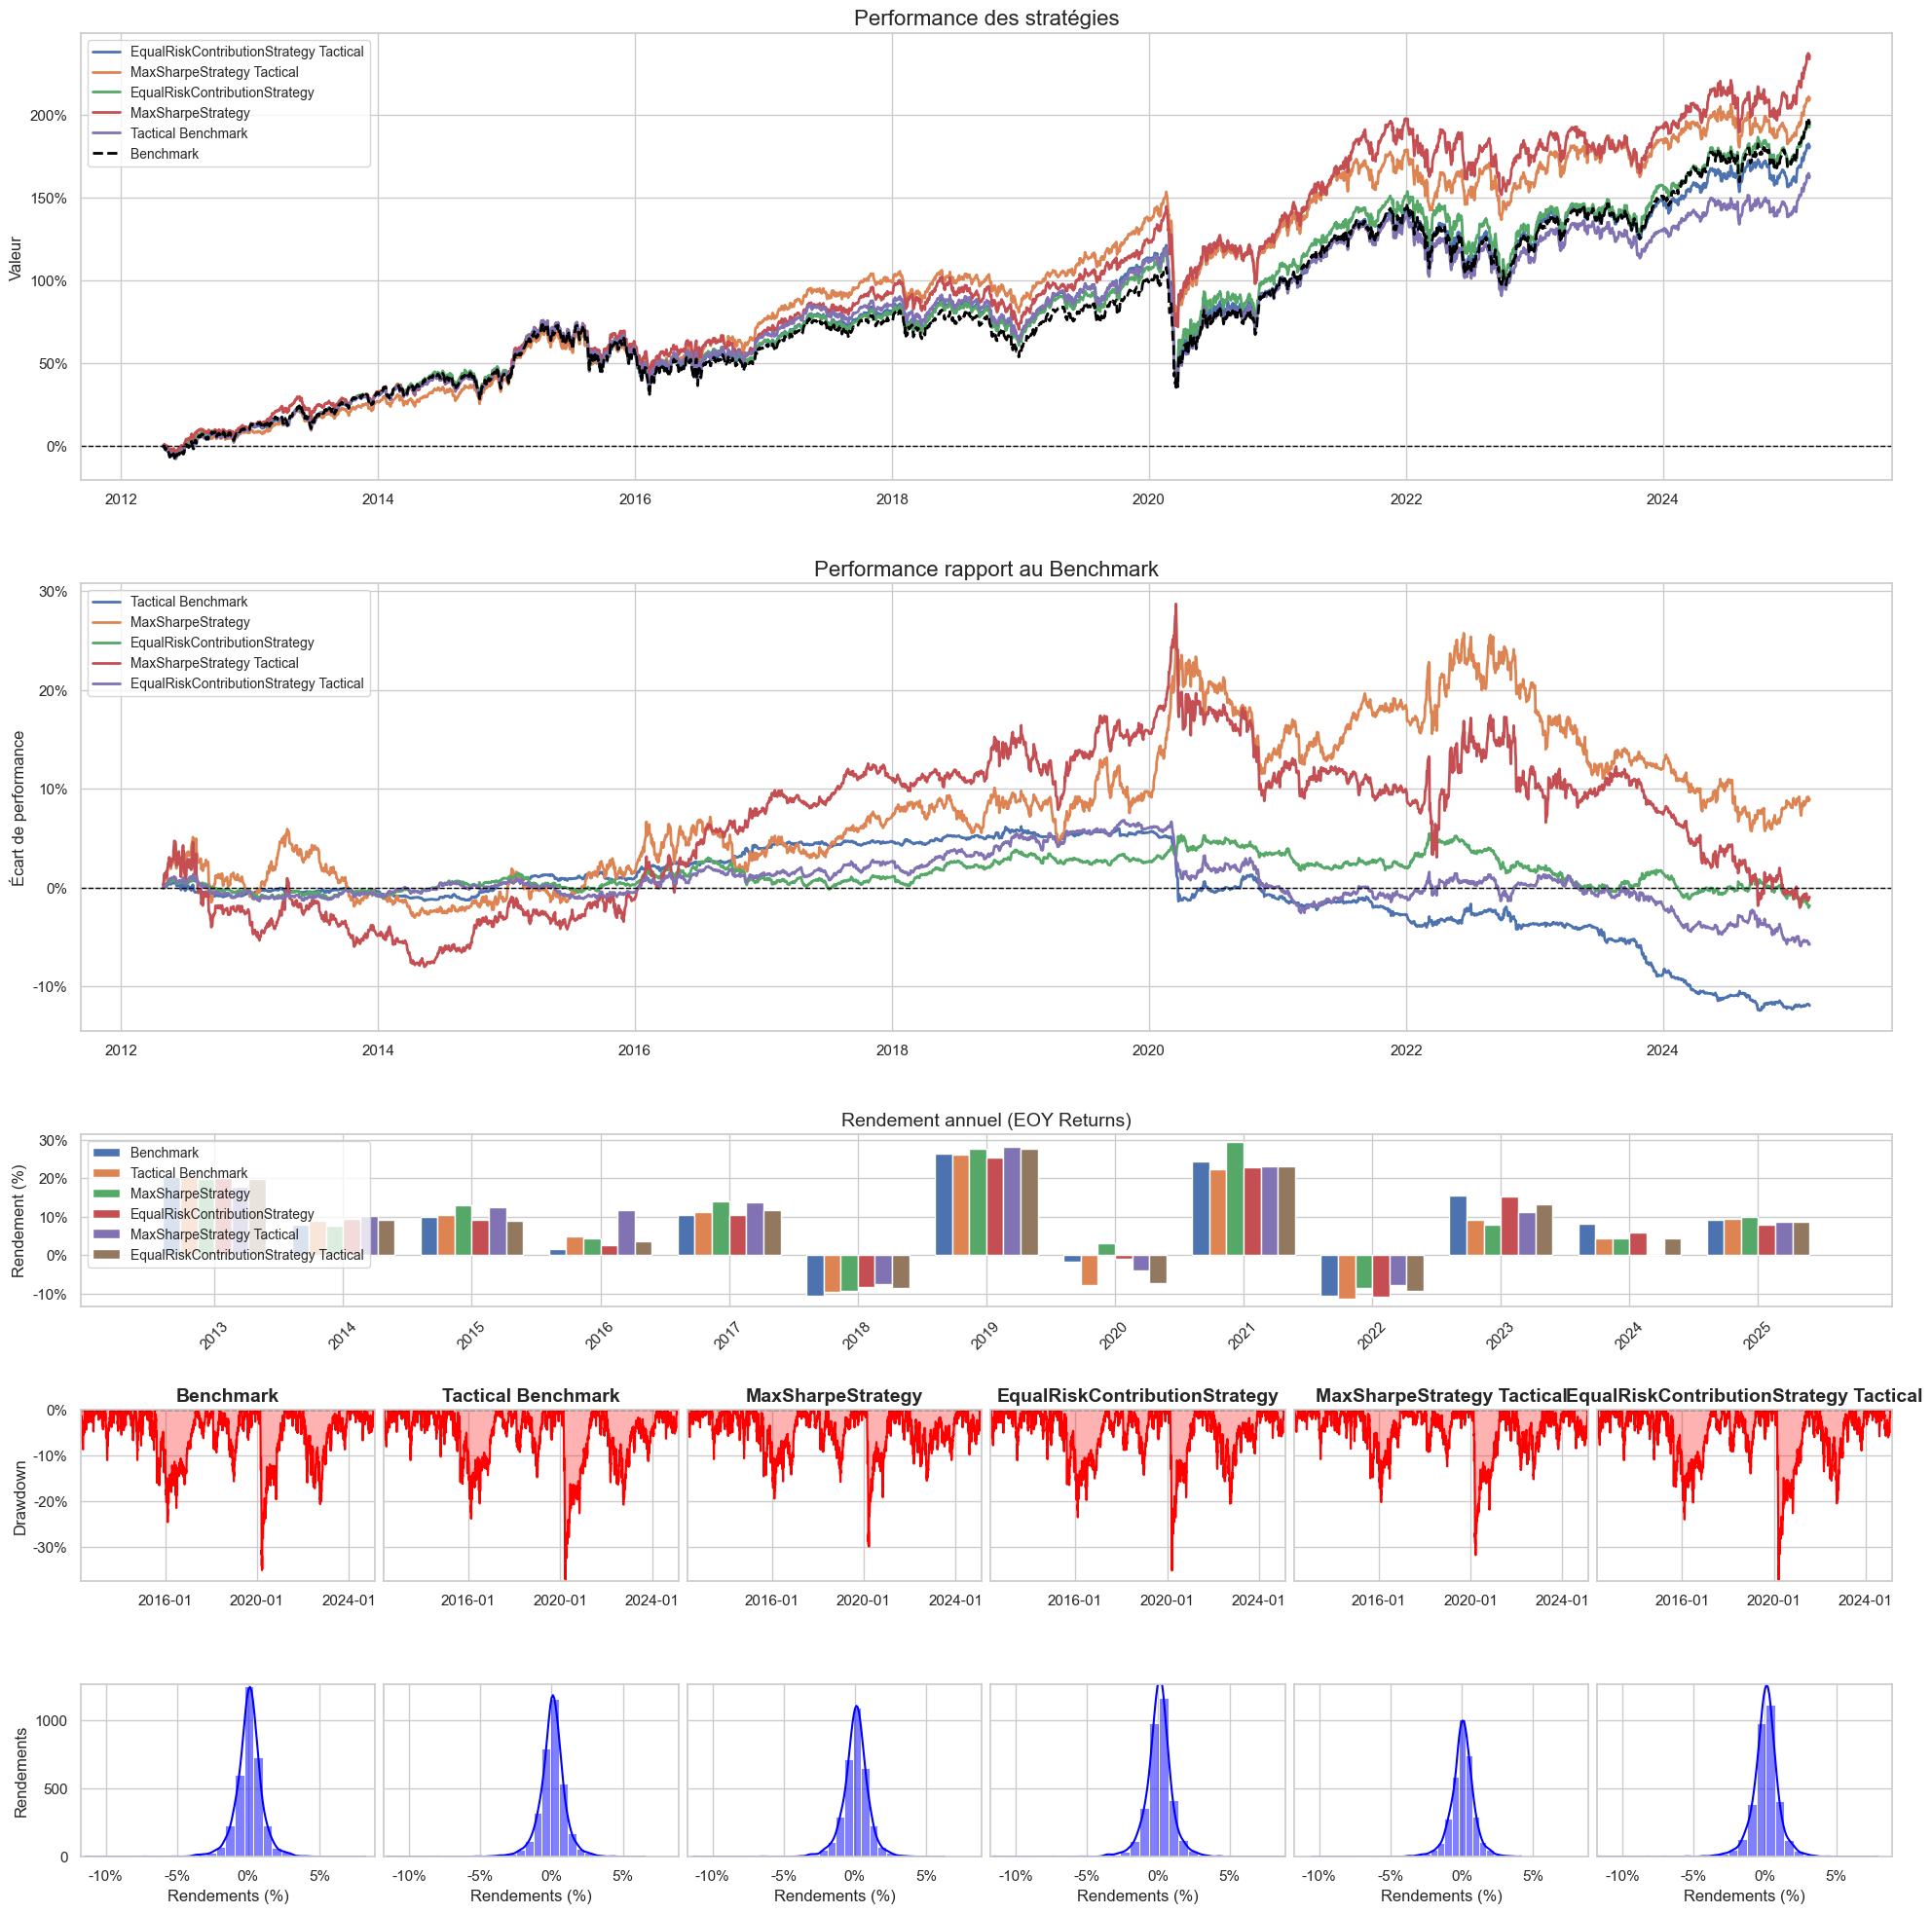

|                              | Benchmark   | Tactical Benchmark   | MaxSharpeStrategy   | EqualRiskContributionStrategy   | MaxSharpeStrategy Tactical   | EqualRiskContributionStrategy Tactical   |
|:-----------------------------|:------------|:---------------------|:--------------------|:--------------------------------|:-----------------------------|:-----------------------------------------|
| Performance                  | 196.20%     | 162.99%              | 235.83%             | 194.02%                         | 210.33%                      | 181.11%                                  |
| CAGR                         | 8.67%       | 7.68%                | 9.72%               | 8.61%                           | 9.06%                        | 8.23%                                    |
| Volatility                   | 15.42%      | 15.10%               | 14.73%              | 15.28%                          | 13.83%                       | 15.24%                                   |


In [ ]:
MSM.compare(ERCM)

In [ ]:
MS.positions('benchmark')
MS.positions()

NameError: name 'MS' is not defined

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def rolling_regression_R2(y, X, window=60):
    """
    Calcule le R² d'une régression linéaire sur une fenêtre roulante.
    
    Args:
        y (pd.Series): Série temporelle du benchmark.
        X (pd.Series): Série temporelle d'un secteur.
        window (int): Taille de la fenêtre roulante.
    
    Returns:
        pd.Series: R² pour chaque fenêtre roulante.
    """
    r2_values = []
    # Indices sur lesquels le R² sera calculé
    index = y.index[window - 1:]
    for i in range(window, len(y) + 1):
        y_window = y.iloc[i - window:i]
        X_window = X.iloc[i - window:i]
        # Ajout d'une constante pour l'intercept
        X_window_const = sm.add_constant(X_window)
        model = sm.OLS(y_window, X_window_const).fit()
        r2_values.append(model.rsquared)
    return pd.Series(r2_values, index=index)

# Supposons que benchmark contient les rendements du benchmark
# et sectors est un DataFrame où chaque colonne correspond aux rendements d'un secteur.
# Par exemple, vous pouvez calculer les rendements si ce sont des prix :
# benchmark = benchmark.pct_change().dropna()
# sectors = sectors.pct_change().dropna()

window = 365  # fenêtre de 60 périodes

# Créer un dictionnaire pour stocker le R² roulants pour chaque secteur
rolling_r2 = {}

for sector in sectors.columns:
    # Assurez-vous que les index des séries sont alignés
    aligned_data = pd.concat([benchmark, sectors[sector]], axis=1, join='inner')
    aligned_data.columns = ['benchmark', 'sector']
    r2_series = rolling_regression_R2(aligned_data['benchmark'], aligned_data['sector'], window)
    rolling_r2[sector] = r2_series

# Par exemple, pour afficher le R² roulant d'un secteur donné :
sector_to_plot = sectors.columns[0]
for sector_to_plot in sectors.columns:
    rolling_r2[sector_to_plot].plot(title=f"Rolling R² for sector: {sector_to_plot}")

NameError: name 'benchmark' is not defined

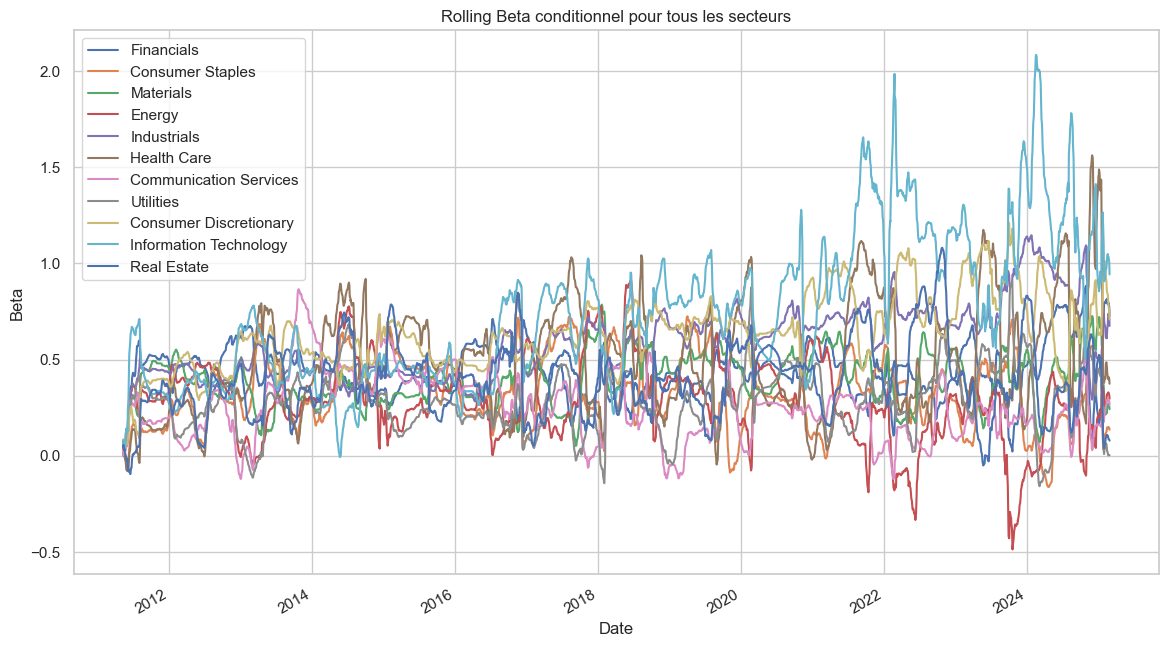

In [ ]:
def rolling_beta_ewma(benchmark: pd.Series, sector: pd.Series, span: int = 60) -> pd.Series:
    """
    Calcule le beta roulant conditionnel à l'aide d'un estimateur EWMA.
    
    Args:
        benchmark (pd.Series): Série temporelle des rendements du benchmark.
        sector (pd.Series): Série temporelle des rendements du secteur.
        span (int): Période utilisée pour l'estimation EWMA (plus faible span => plus de poids aux observations récentes).
        
    Returns:
        pd.Series: Série temporelle du beta conditionnel.
    """
    # Calcul de la covariance conditionnelle (EWMA)
    rolling_cov = benchmark.ewm(span=span, adjust=False).cov(sector)
    # Calcul de la variance conditionnelle du benchmark (EWMA)
    rolling_var = benchmark.ewm(span=span, adjust=False).var()
    # Calcul du beta conditionnel : beta = cov / var
    beta = rolling_cov / rolling_var
    return beta

# Calculer les beta conditionnels pour tous les secteurs
beta_sectors = {}
for sector in sectors.columns:
    beta_sectors[sector] = rolling_beta_ewma(benchmark.squeeze(), sectors[sector], span=60)

# Tracer les beta conditionnels pour tous les secteurs sur un même graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for sector, beta_series in beta_sectors.items():
    beta_series.plot(label=sector)

plt.title("Rolling Beta conditionnel pour tous les secteurs")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.show()

In [ ]:
benchmark

,SXXP Index
Date,
2000-01-03,377.69
2000-01-04,362.70
2000-01-05,353.74
2000-01-06,352.21
2000-01-07,359.75
...,...
2025-02-20,551.01
2025-02-21,553.85
2025-02-24,553.39
